## Submission by : Mridul Krishnan(50049451), Mansi Pandit (50127715)

In [1]:
!nvidia-smi

Wed May  1 20:25:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install torch torchvision torchaudio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
print(torch.__version__)
train_dataset = datasets.SVHN(root='./data', split='train', transform=transforms.ToTensor(), download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transforms.ToTensor(), download=True)

2.2.1+cu121


100%|██████████| 182040794/182040794 [00:20<00:00, 9092500.42it/s]


100%|██████████| 64275384/64275384 [00:08<00:00, 7250803.29it/s]


In [4]:
torch.cuda.is_available()

True

In [5]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")


# Images Train: 73257
# Images Test:  26032


In [6]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 1


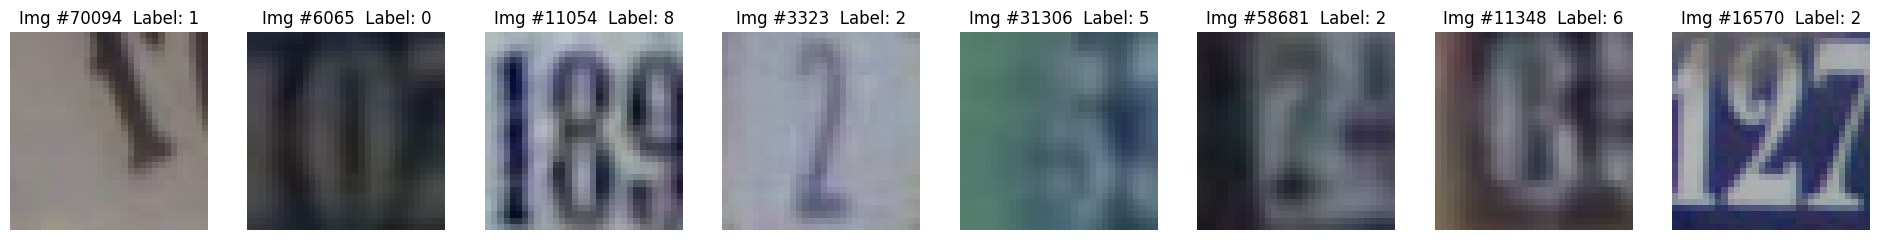

In [7]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3, 32, 32).transpose(1, 2, 0)  # Reshape image
    label = train_dataset[n][1]  # Access label
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

plt.show()


## Setting up the model

In [8]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

In [9]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [10]:
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 3, 32, 32])
labels.shape = torch.Size([1024])


In [11]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=512, output_dim=10):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )

    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [12]:
model = Model(input_dim=3072, hidden_dim=512, output_dim=10)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
count_model_params(model)

1578506

In [14]:
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.flatten(start_dim=1)  # reshaping to desired size
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

Imgs shape:         torch.Size([1024, 3, 32, 32])
Model input shape:  torch.Size([1024, 3072])
Model output shape: torch.Size([1024, 10])


## Training the model

In [15]:
from tqdm import tqdm

In [16]:
NUM_EPOCHS = 10
LR = 3e-4

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=3072, hidden_dim=256, output_dim=10)
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [19]:
loss_list = []

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)

        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()

        # backprogating error to compute gradients
        loss.backward()

        # updating arameters
        optimizer.step()

        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 72: loss 1.34445. : 100%|██████████| 72/72 [00:11<00:00,  6.22it/s]


In [20]:
#loss_list = []
#this section is being used to repeat further epochs
for epoch in range(10,30):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)

        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()

        # backprogating error to compute gradients
        loss.backward()

        # updating arameters
        optimizer.step()

        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 30 Iter 72: loss 0.98342. : 100%|██████████| 72/72 [00:11<00:00,  6.34it/s]


In [21]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

<ipython-input-22-8e202edc2456>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


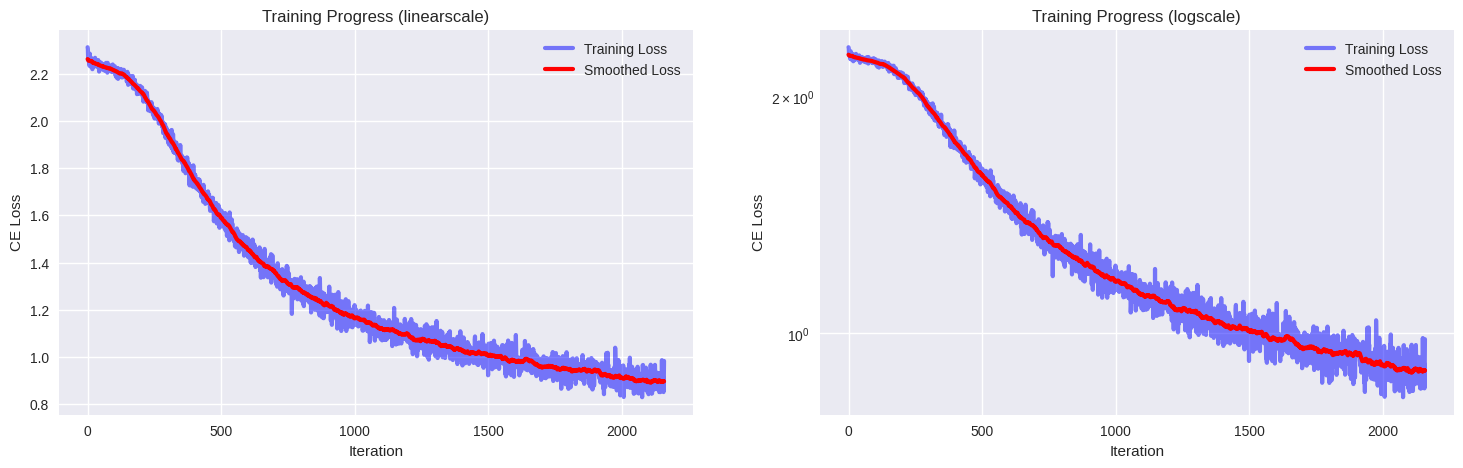

In [22]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(loss_list, 31)
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

## Evaluating trained model

100%|██████████| 26/26 [00:04<00:00,  5.68it/s]


Test accuracy: 69.57%


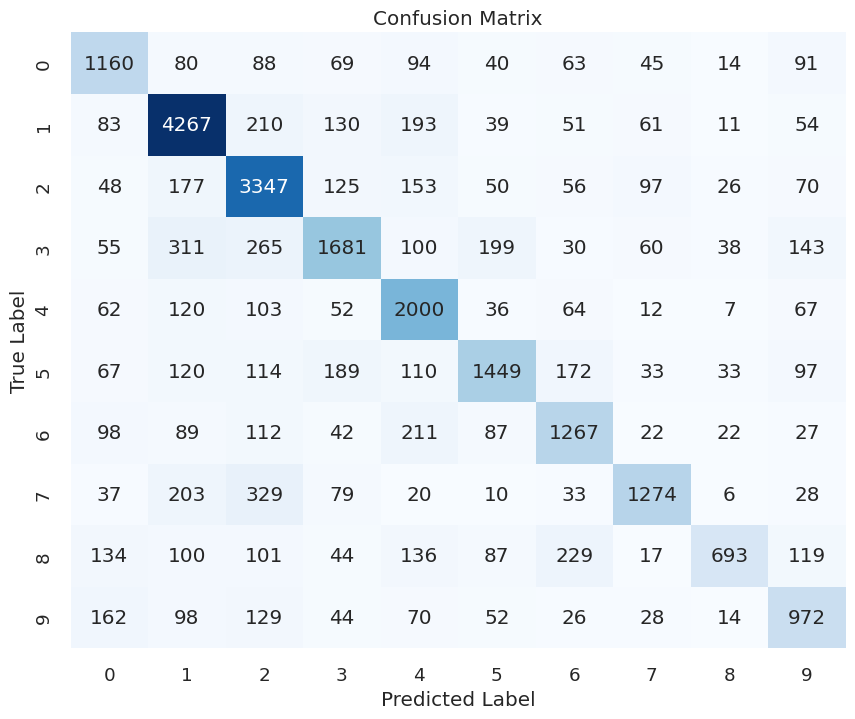

In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

n_correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar:
        # Everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # Get predicted labels and update correct predictions count
        pred_labels = torch.argmax(preds, dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct += cur_correct

        # Collect predictions and labels for confusion matrix
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy, 2)}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sn.set(font_scale=1.2)  # Adjust font size for better readability
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
import os
if(not os.path.exists("models")):
    os.makedirs("models")
savepath = f"models/hl512_lr3e4_checkpoint_epoch_{epoch}.pth"

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)

## Visualising test images and predicted labels

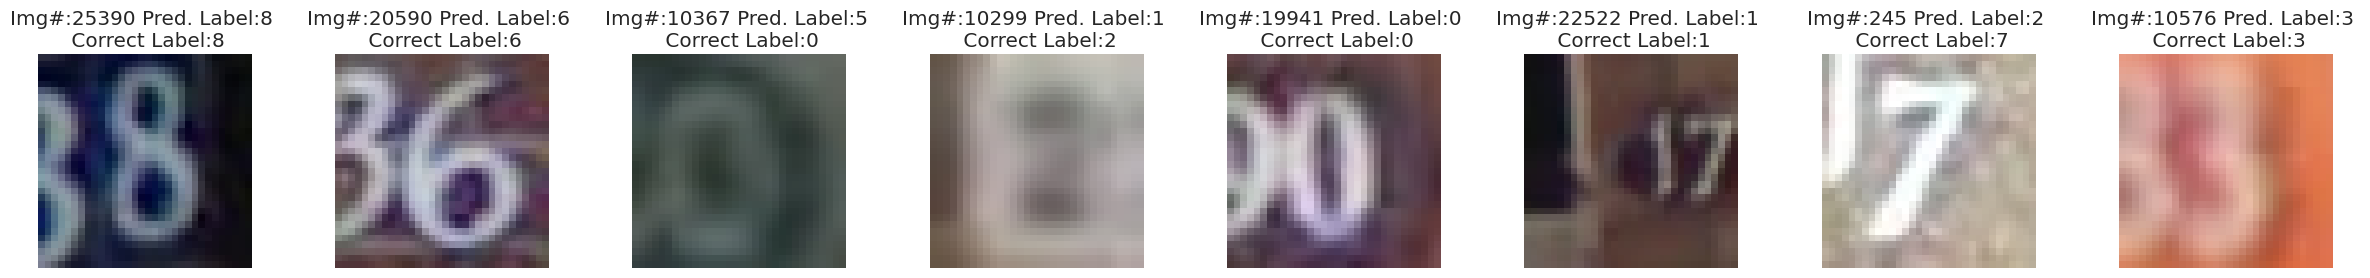

In [27]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)
fig.tight_layout()

ids = np.random.randint(low=0, high=len(test_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    # Get image and label
    img, correct_label = test_dataset[n]
    show_img = img.numpy().reshape(3, 32, 32).transpose(1, 2, 0)
    # Predict
    with torch.no_grad():
        # Forward pass
        img_tensor = img.unsqueeze(0)  # add batch dimension
        flattened_img = img_tensor.flatten(start_dim=1)
        pred = model(flattened_img.to(device)).argmax(dim=1)
    label = pred.item()
    # Display image with prediction
    ax[i].imshow(show_img)
    ax[i].set_title(f"Img#:{n} Pred. Label:{label} \n Correct Label:{correct_label}")
    ax[i].axis("off")

plt.show()

## Optuna hyperparameter tuning and visualizations
using https://hvy-optuna.readthedocs.io/ for reference


In [30]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 13.4 MB/s eta 0:00:00


In [31]:
import torch.nn.functional as F
import torchvision

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [71]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
BATCH_SIZE = 512
SEED = 2024
N_TRAIN_SAMPLES = BATCH_SIZE * 70

In [72]:
def train_model(model, optimizer, train_loader):
    model.train()

    progress_bar = tqdm(train_loader, total=N_TRAIN_SAMPLES//BATCH_SIZE)
    for i, (imgs, labels) in enumerate(progress_bar):
        if i * BATCH_SIZE >= N_TRAIN_SAMPLES:
                break
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)

        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        # computing error
        loss = criterion(preds, labels)

        # removing accumulated gradients
        optimizer.zero_grad()

        # backprogating error to compute gradients
        loss.backward()

        # updating arameters
        optimizer.step()

def eval_model(model, eval_loader):
    model.eval()

    n_correct = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
        for i, (imgs, labels) in progress_bar:
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            preds = model(flattened_imgs)

            pred_labels = torch.argmax(preds, dim=-1)
            cur_correct = len(torch.where(pred_labels == labels)[0])
            n_correct = n_correct + cur_correct

    accuracy = n_correct / len(test_dataset) * 100
    return accuracy

In [73]:
def objective(trial):
    layers = []
    in_features = 3 * 32 * 32
    for i in range(3):
        # Optimize the number of units of each layer and the initial learning rate.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, 10))
    model = nn.Sequential(*layers).to(device)
    # Sample the initial learning rate from [1e-5, 1e-1] in log space.
    optimizer = torch.optim.Adam(
        model.parameters(), trial.suggest_float("lr_init", 1e-5, 1e-1, log=True)
    )

    for step in range(10):
        model.train()
        train_model(model, optimizer, train_loader)

        accuracy = eval_model(model, eval_loader)

        # Report intermediate objective value.
        trial.report(accuracy, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()

    return accuracy


In [74]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-05-01 21:48:38,159] A new study created in memory with name: no-name-0eca05d5-19dd-4ab6-a209-4a303019141d
100%|██████████| 26/26 [00:03<00:00,  7.12it/s]
[I 2024-05-01 21:51:09,584] Trial 0 finished with value: 19.618162261831593 and parameters: {'n_units_l0': 77, 'n_units_l1': 91, 'n_units_l2': 27, 'lr_init': 1.497042931399778e-05}. Best is trial 0 with value: 19.618162261831593.
100%|██████████| 26/26 [00:03<00:00,  6.94it/s]
[I 2024-05-01 21:53:42,011] Trial 1 finished with value: 37.94176398279041 and parameters: {'n_units_l0': 29, 'n_units_l1': 17, 'n_units_l2': 94, 'lr_init': 0.005219177824358986}. Best is trial 1 with value: 37.94176398279041.
100%|██████████| 26/26 [00:04<00:00,  5.42it/s]
[I 2024-05-01 21:56:23,645] Trial 2 finished with value: 19.587430854333128 and parameters: {'n_units_l0': 63, 'n_units_l1': 60, 'n_units_l2': 6, 'lr_init': 0.010242202281967362}. Best is trial 1 with value: 37.94176398279041.
100%|██████████| 26/26 [00:03<00:00,  6.80it/s]
[I 2024-05

In [75]:
plot_intermediate_values(study)

In [76]:
plot_parallel_coordinate(study)

In [77]:
plot_param_importances(study)

63.322065150583896
